In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Importing the dataset

In [2]:
df= pd.read_csv("Dataset_01.csv")


## Showing ten random rows

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

random_rows = df.sample(n=10)
random_rows

,Unnamed: 0,index,age,job_category,edu,edu_level,marriage,job,rel,race,sex,gain,loss,hours-per-week,nationality,salary
7762,7762,7762,56,Private,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
23881,23881,23881,25,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Own-child,Other,Male,0,0,40,United-States,<=50K
30507,30507,30507,43,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,14344,0,40,United-States,>50K
28911,28911,28911,32,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
19484,19484,19484,39,Private,Bachelors,13,Married-civ-spouse,Sales,Wife,White,Female,0,0,30,United-States,<=50K
43031,43031,43031,20,Private,HS-grad,9,Never-married,Adm-clerical,Unmarried,White,Female,0,0,40,Germany,<=50K
28188,28188,28188,54,Private,HS-grad,9,Divorced,Transport-moving,Not-in-family,White,Male,0,0,45,United-States,<=50K
12761,12761,12761,25,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,1887,40,United-States,>50K
40834,40834,40834,30,Private,HS-grad,9,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,50,Dominican-Republic,<=50K
27875,27875,27875,33,Private,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,40,United-States,<=50K


## Since Unnamed:0 and index are identical with the pandas indexing, we can drop them 

In [4]:
df = df.drop(["Unnamed: 0", "index"], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   job_category    48842 non-null  object
 2   edu             48842 non-null  object
 3   edu_level       48842 non-null  int64 
 4   marriage        48842 non-null  object
 5   job             48842 non-null  object
 6   rel             48842 non-null  object
 7   race            48842 non-null  object
 8   sex             48842 non-null  object
 9   gain            48842 non-null  int64 
 10  loss            48842 non-null  int64 
 11  hours-per-week  48842 non-null  int64 
 12  nationality     48842 non-null  object
 13  salary          48842 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.2+ MB


## Check if there are Nan values

In [6]:
df.isnull().sum()

age               0
job_category      0
edu               0
edu_level         0
marriage          0
job               0
rel               0
race              0
sex               0
gain              0
loss              0
hours-per-week    0
nationality       0
salary            0
dtype: int64

Transforming object dtypes to string

In [7]:
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].astype("string")

check the counts of each categorical column

In [8]:
for col in df.columns:
    if df[col].dtype == "string":
        print(f"{col}: {df[col].value_counts()}")

job_category: job_category
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: Int64
edu: edu
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: Int64
marriage: marriage
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: count, dtype: Int64
job: job
Prof-specialty       6172
Craft-repair         6112
Exe

## Insights:
- there are ? values rather than Nan in categorical columns
- dataset is binary classified
- US has the majority of nationality category. there are some countries with few counts which increases the cardinality of the column. so it is better to transform nationality into a more big picture class like : US, south america, eastern europe, western europe, and asia
- there is also a South category which is not so correct so I will transform it into ? 
- We can Also put 12th 11th to 7th-8th into one category

In [9]:
# Mapping dictionary for broader categories
nationality_mapping = {
    'United-States': 'US',
    'Mexico': 'NorthAmerica',
    'Canada': 'NorthAmerica',
    'Puerto-Rico': 'NorthAmerica',
    'El-Salvador': 'NorthAmerica',
    'Guatemala': 'NorthAmerica',
    'Cuba': 'NorthAmerica',
    'Jamaica': 'NorthAmerica',
    'Haiti': 'NorthAmerica',
    'Dominican-Republic': 'NorthAmerica',
    'Outlying-US(Guam-USVI-etc)': 'US',
    'South': '?',
    'Columbia': 'SouthAmerica',
    'Peru': 'SouthAmerica',
    'Ecuador': 'SouthAmerica',
    'Nicaragua': 'SouthAmerica',
    'Trinadad&Tobago': 'SouthAmerica',
    'Honduras': 'SouthAmerica',
    'England': 'WesternEurope',
    'Germany': 'WesternEurope',
    'Italy': 'WesternEurope',
    'Poland': 'EasternEurope',
    'Hungary': 'EasternEurope',
    'Portugal': 'WesternEurope',
    'Ireland': 'WesternEurope',
    'France': 'WesternEurope',
    'Scotland': 'WesternEurope',
    'Yugoslavia': 'EasternEurope',
    'Greece': 'WesternEurope',
    'Holand-Netherlands': 'WesternEurope',
    'Philippines': 'Asia',
    'India': 'Asia',
    'China': 'Asia',
    'Vietnam': 'Asia',
    'Taiwan': 'Asia',
    'Iran': 'Asia',
    'Hong': 'Asia',
    'Cambodia': 'Asia',
    'Thailand': 'Asia',
    'Laos': 'Asia',
    'Japan': 'Asia',
    '?': '?'
}

# Map nationality to broader categories
df['nationality'] = df['nationality'].map(nationality_mapping)

# Display the transformed column
df['nationality'].value_counts()

nationality
US               43855
NorthAmerica      1982
Asia               981
?                  972
WesternEurope      651
SouthAmerica       272
EasternEurope      129
Name: count, dtype: int64

In [10]:
# Mapping dictionary for broader categories
education_mapping = {
    'HS-grad': 'HS-grad',
    'Some-college': 'Some-college',
    'Bachelors': 'Bachelors',
    'Masters': 'Masters',
    'Assoc-voc': 'Assoc-voc',
    '11th': 'Less than High School',
    'Assoc-acdm': 'Assoc-acdm',
    '10th': 'Less than High School',
    '7th-8th': 'Less than High School',
    'Prof-school': 'Prof-school',
    '9th': 'Less than High School',
    '12th': 'Less than High School',
    'Doctorate': 'Doctorate'
}

# Map education level to broader categories
df['edu'] = df['edu'].map(education_mapping)

# Display the transformed column
df['edu'].value_counts()

edu
HS-grad                  15784
Some-college             10878
Bachelors                 8025
Less than High School     5569
Masters                   2657
Assoc-voc                 2061
Assoc-acdm                1601
Prof-school                834
Doctorate                  594
Name: count, dtype: int64

In [11]:
salary_mapping = {
    "<=50K": 0 , 
    ">50K":1
}

df['salary'] = df['salary'].map(salary_mapping)

df['salary'].value_counts()

salary
0    37155
1    11687
Name: count, dtype: int64

## Handling missing values

I will try two methods for handling missing values: 
- impute with mode
- Delete the rows containing missing values <br>
I will train a random forest on each method then I will evaluate each method using AUC 

In [12]:
#replace "?" with Nan
df= df.replace({"?": None})
# Replace 'None' values with NaN
df.fillna(value=np.nan, inplace=True)

,age,job_category,edu,edu_level,marriage,job,rel,race,sex,gain,loss,hours-per-week,nationality,salary
0,25,Private,Less than High School,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,US,0
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,US,0
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,US,1
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,US,1
4,18,NaN,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,US,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,US,0
48838,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,US,1
48839,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,US,0
48840,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,US,0


let's create a pipeline for sake of ease

### mode imputation

In [13]:
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(["salary"], axis=1), df["salary"], train_size=0.6, test_size=0.4,random_state=0)
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ["string",'object'] ]
# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

In [14]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [15]:
numerical_transformer = MinMaxScaler()

In [16]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [17]:
model = RandomForestClassifier(n_estimators=100, random_state=0)

In [18]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [20]:
# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['age', 'edu_level', 'gain',
                                                   'loss', 'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job_category', 'edu',
                                                   'marriage', 'job', 'rel',
                                                   'race', 'sex',
                                                   'nationality'])])),
                ('model', RandomForestClassifier(random_state=0))])

In [21]:
# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

In [22]:
auc = roc_auc_score(y_valid, preds)
auc

0.7689806791903727

### Deleting rows containing missing values

In [23]:
new_df= df.dropna()

In [24]:
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(new_df.drop(["salary"], axis=1), new_df["salary"], train_size=0.6, test_size=0.4,random_state=0)
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ["string",'object'] ]
# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

In [25]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [26]:
numerical_transformer = MinMaxScaler()

In [27]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [28]:
model = RandomForestClassifier(n_estimators=100, random_state=0)

In [29]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [30]:
# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['age', 'edu_level', 'gain',
                                                   'loss', 'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job_category', 'edu',
                                                   'marriage', 'job', 'rel',
                                                   'race', 'sex',
                                                   'nationality'])])),
                ('model', RandomForestClassifier(random_state=0))])

In [31]:
# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

In [32]:
auc = roc_auc_score(y_valid, preds)
auc

0.7653768485907195

## Result:
- imputation performed slightly better

## impute the missing values with mode

In [33]:

# Replace 'None' values with NaN
df.fillna(value=np.nan, inplace=True)

# Create a SimpleImputer instance
imputer = SimpleImputer(strategy='most_frequent')

# Fit and transform your data with the imputer
imputed_array = imputer.fit_transform(df)
imputed_df = pd.DataFrame(imputed_array, columns=df.columns)

In [34]:
imputed_df.isnull().sum()

age               0
job_category      0
edu               0
edu_level         0
marriage          0
job               0
rel               0
race              0
sex               0
gain              0
loss              0
hours-per-week    0
nationality       0
salary            0
dtype: int64

In [35]:
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  object
 1   job_category    48842 non-null  object
 2   edu             48842 non-null  object
 3   edu_level       48842 non-null  object
 4   marriage        48842 non-null  object
 5   job             48842 non-null  object
 6   rel             48842 non-null  object
 7   race            48842 non-null  object
 8   sex             48842 non-null  object
 9   gain            48842 non-null  object
 10  loss            48842 non-null  object
 11  hours-per-week  48842 non-null  object
 12  nationality     48842 non-null  object
 13  salary          48842 non-null  object
dtypes: object(14)
memory usage: 5.2+ MB


### since the Dtypes are broken, we have to fix the first

In [36]:
for col in imputed_df.columns:
    if col in numerical_cols:
        imputed_df[col] = imputed_df[col].astype("float64")

In [37]:
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  float64
 1   job_category    48842 non-null  object 
 2   edu             48842 non-null  object 
 3   edu_level       48842 non-null  float64
 4   marriage        48842 non-null  object 
 5   job             48842 non-null  object 
 6   rel             48842 non-null  object 
 7   race            48842 non-null  object 
 8   sex             48842 non-null  object 
 9   gain            48842 non-null  float64
 10  loss            48842 non-null  float64
 11  hours-per-week  48842 non-null  float64
 12  nationality     48842 non-null  object 
 13  salary          48842 non-null  object 
dtypes: float64(5), object(9)
memory usage: 5.2+ MB


## Data visualization

Visualization of the categorical columns using bar plots

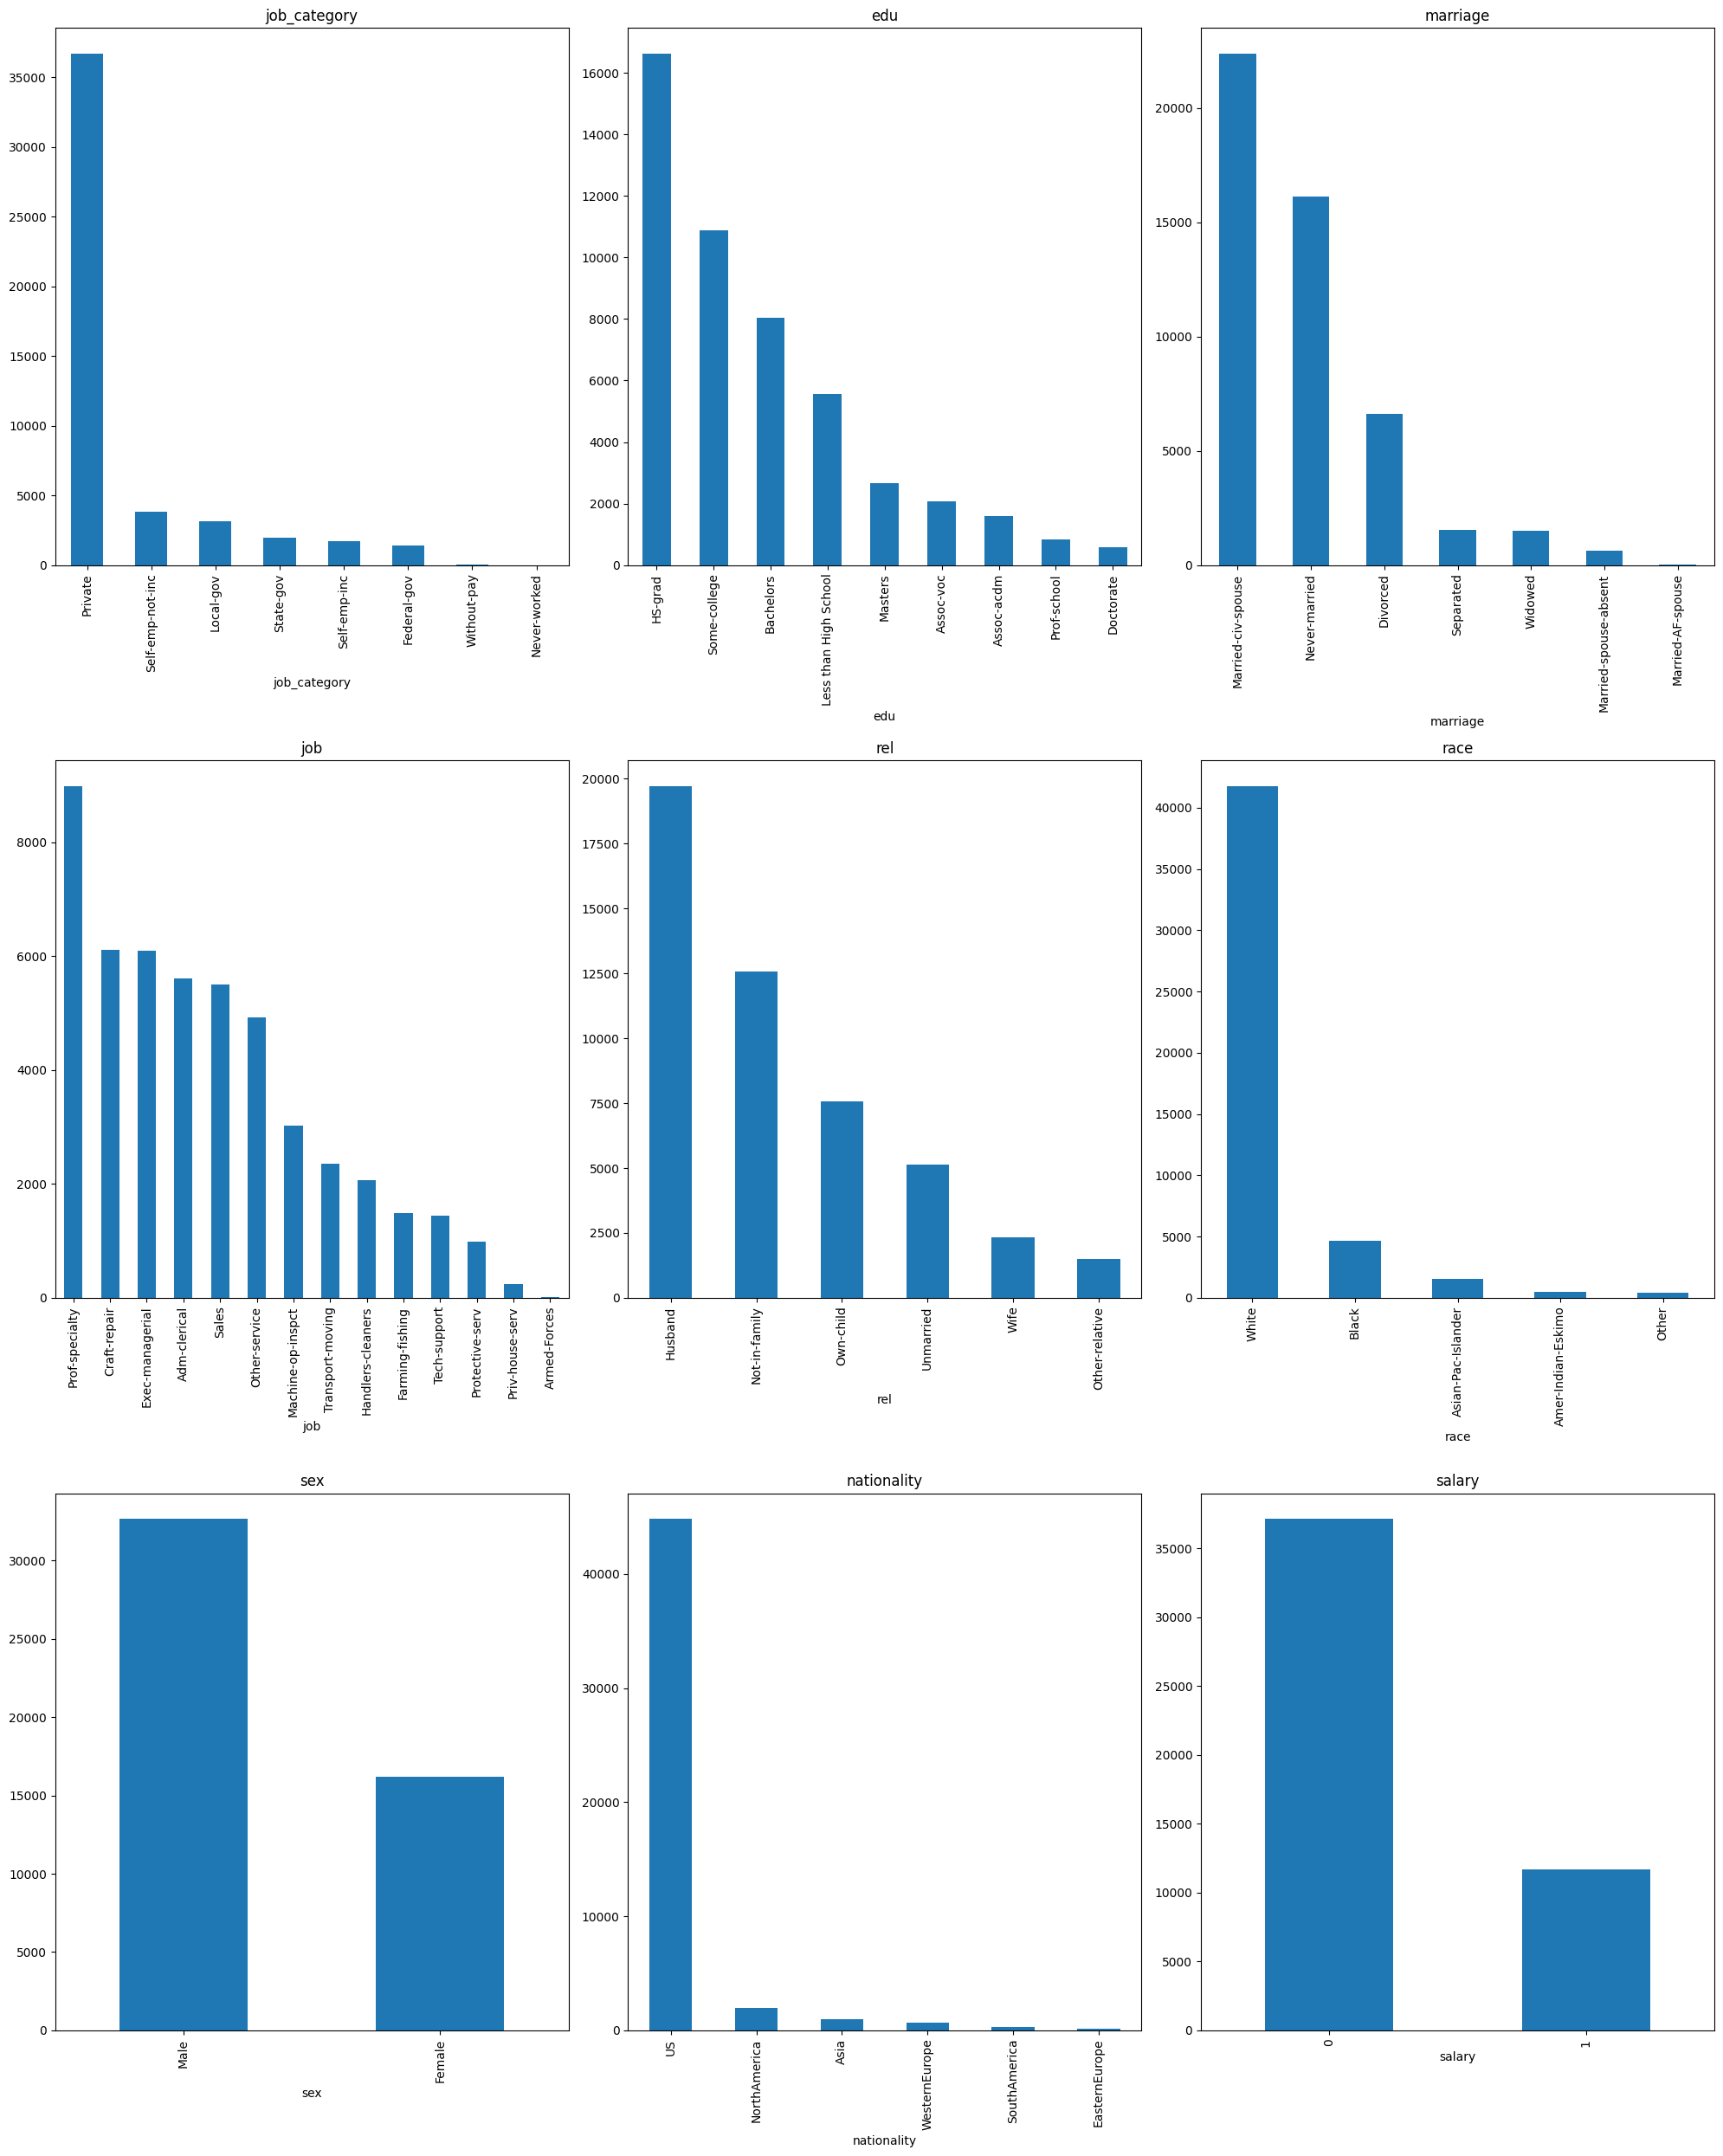

In [38]:
import matplotlib.pyplot as plt

# Filter categorical columns
categorical_columns = imputed_df.select_dtypes(include=['object', 'string'])

# Calculate the number of rows and columns needed for subplots
num_rows = 3
num_cols = 3

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot bar plots for each categorical column
for i, col in enumerate(categorical_columns):
    imputed_df[col].value_counts().plot(kind="bar", ax=axes[i])
    axes[i].set_title(col)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


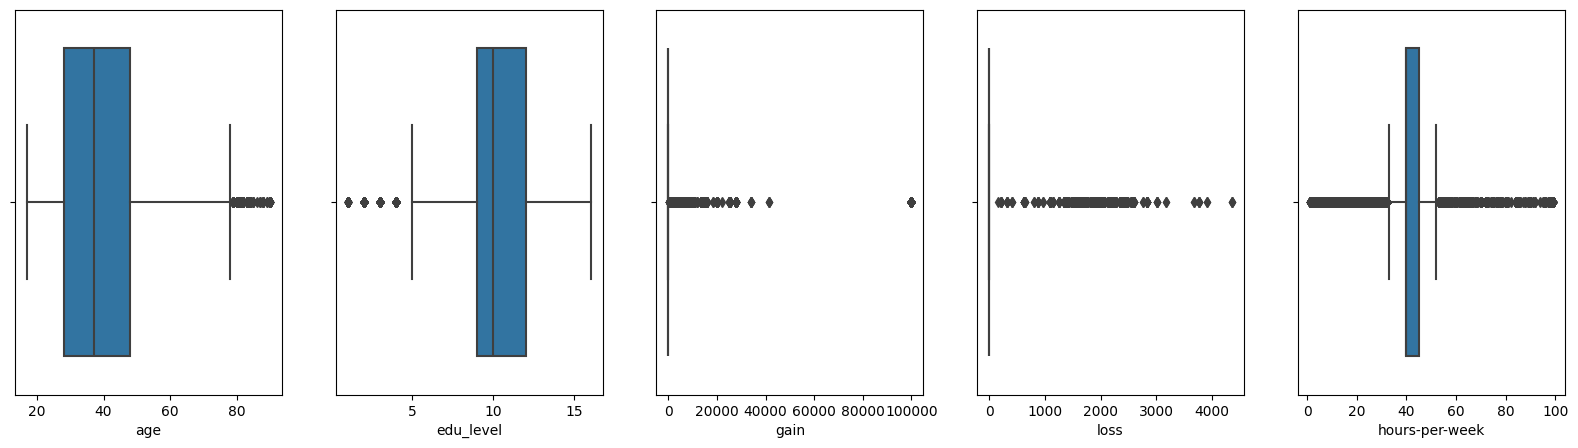

In [39]:
import seaborn as sns
# Calculate the number of rows and columns needed for subplots
num_rows = 1
num_cols = 5

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot boxplots for each column
for i, col in enumerate(imputed_df.loc[:, numerical_cols]):
    sns.boxplot(x=imputed_df[col], ax=axes[i])

# Hide any remaining empty subplots
for i in range(len(imputed_df.columns), len(axes)):
    axes[i].axis('off')


# Show the plot
plt.show()

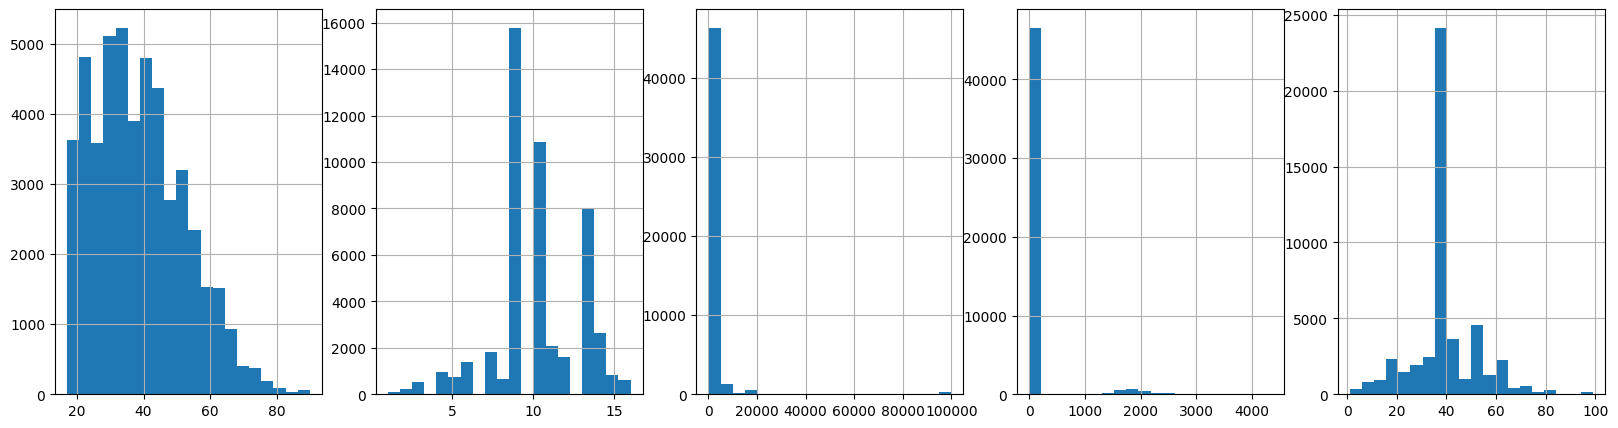

In [40]:
import seaborn as sns
# Calculate the number of rows and columns needed for subplots
num_rows = 1
num_cols = 5

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot boxplots for each column
for i, col in enumerate(imputed_df.loc[:, numerical_cols]):
    imputed_df[col].hist(ax=axes[i], bins=20)

# Hide any remaining empty subplots
for i in range(len(imputed_df.columns), len(axes)):
    axes[i].axis('off')


# Show the plot
plt.show()

Since I plotted the bar plot for the "salary" column, I can safely add it to the "numerical_cols" to plots the correlation plots

In [41]:
numerical_cols.append("salary")

In [42]:
imputed_df["salary"] = imputed_df["salary"].astype("float64")

In [43]:
numerical_cols

['age', 'edu_level', 'gain', 'loss', 'hours-per-week', 'salary']

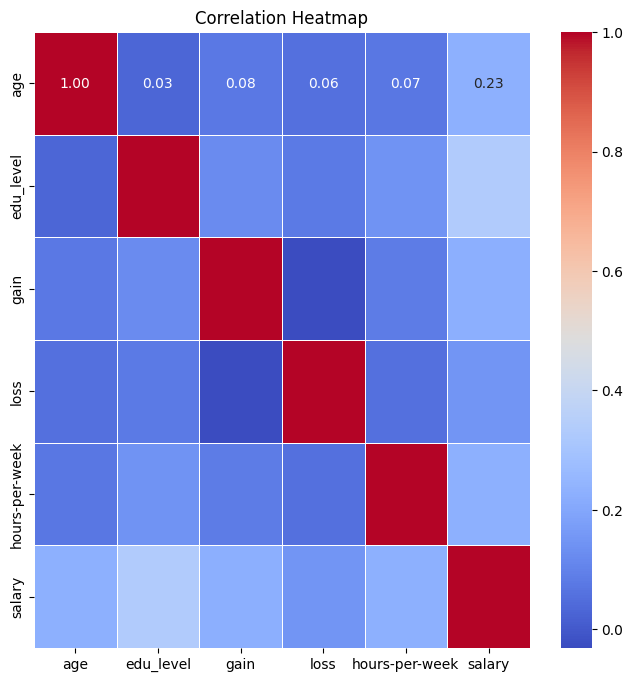

In [44]:
corr_matrix = imputed_df.loc[: , numerical_cols].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

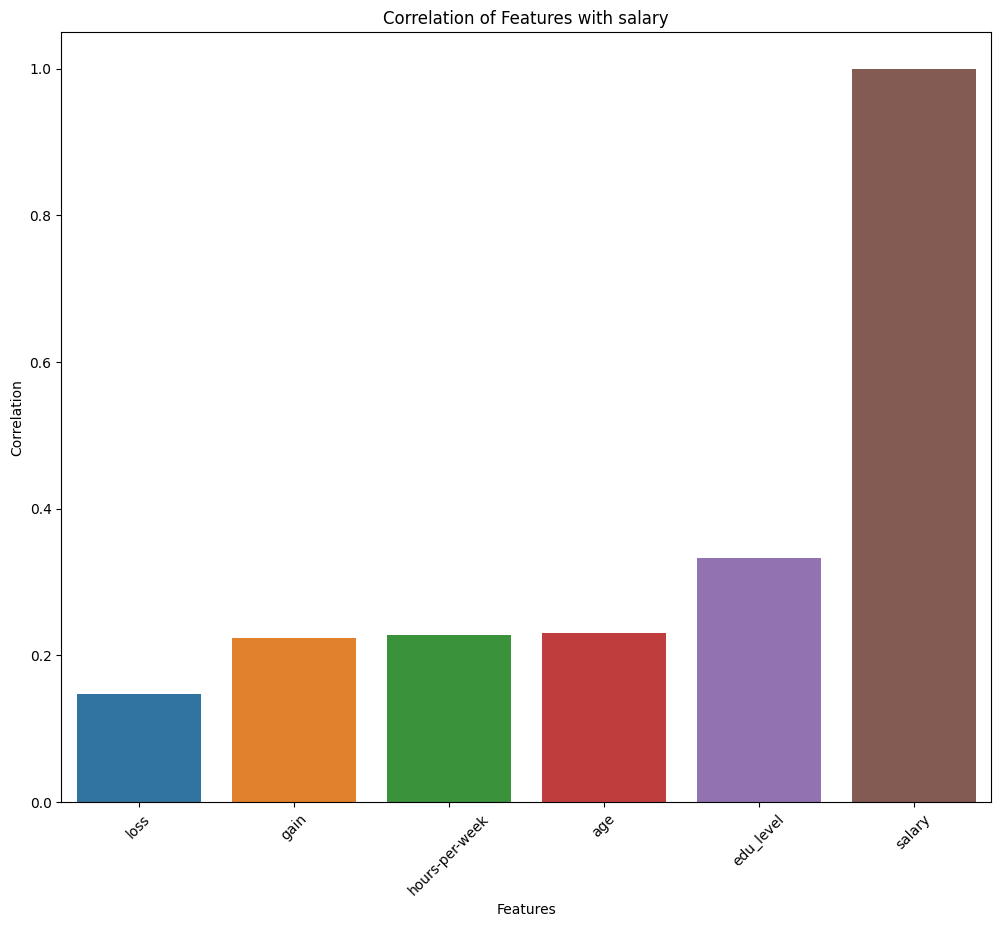

In [45]:
# Compute correlation with label column
correlation = imputed_df.loc[: , numerical_cols].corrwith(imputed_df['salary'])
correlation = correlation.sort_values()
# Plot correlations
plt.figure(figsize=(12, 10))
sns.barplot(x=correlation.index, y=correlation.values)
plt.title('Correlation of Features with salary')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.show()

### checking the correlation of categorical columns

In [46]:
categorical_df = pd.get_dummies(imputed_df.loc[: , categorical_cols])
categorical_df = pd.concat([categorical_df , imputed_df["salary"]])


c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


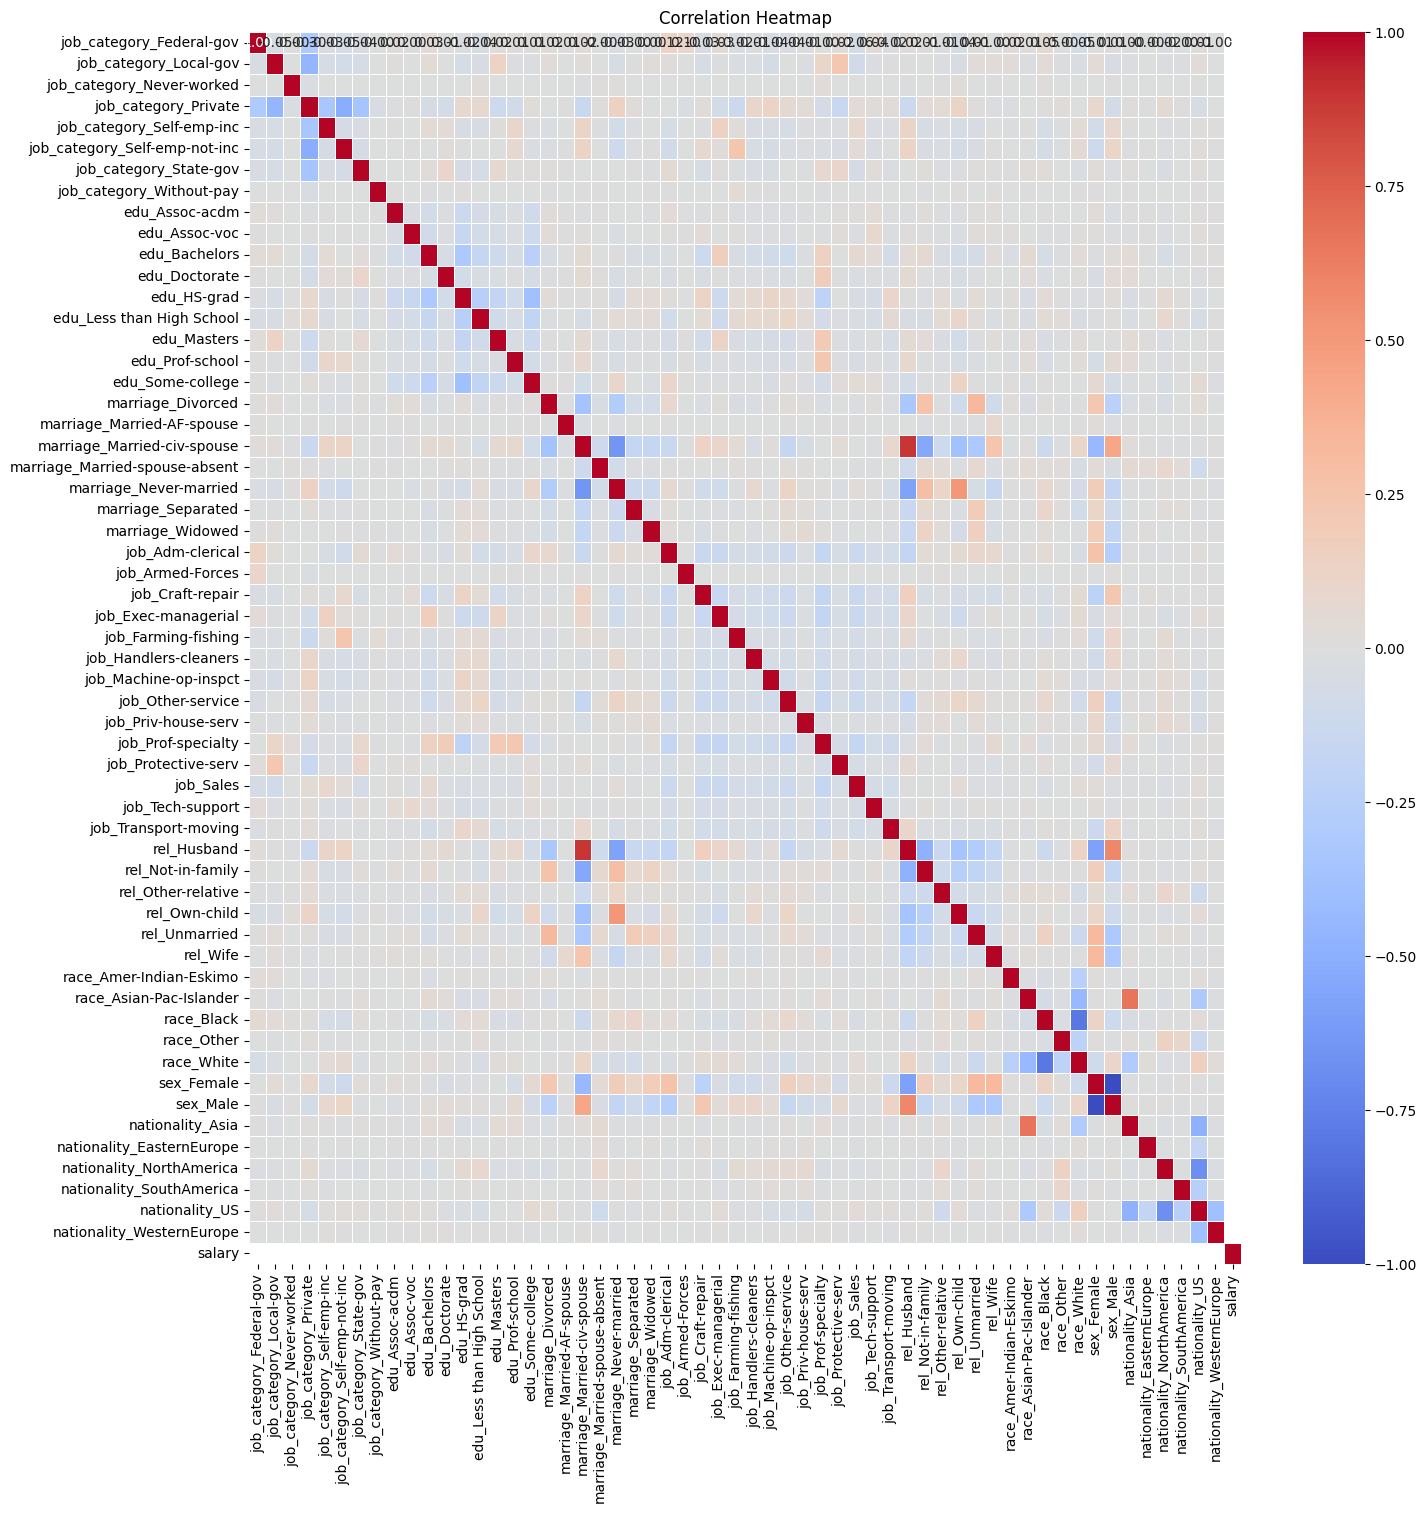

In [47]:
corr_matrix = categorical_df.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## outlier detection

### I will use 3 sigma method to find the outliers <br>
#### Then I will use 2 method for handling outliers:
- smoothing the outliers using median
- deleting the outliers <br>
like before, I will use random forest and AUC to evaluate which method is better

## Deleting the outliers

In [48]:
cleaned_df = imputed_df.copy()  # Create a copy of the original DataFrame

for col in numerical_cols:
    if col != "salary":
        lower_limit = imputed_df[col].mean() - 3 * imputed_df[col].std()
        upper_limit = imputed_df[col].mean() + 3 * imputed_df[col].std()

        # Filter rows to include only values within the threshold
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_limit) & (cleaned_df[col] <= upper_limit)]

# Reset index to ensure a continuous index after deleting rows
cleaned_df.reset_index(drop=True, inplace=True)
cleaned_df

,age,job_category,edu,edu_level,marriage,job,rel,race,sex,gain,loss,hours-per-week,nationality,salary
0,25.0,Private,Less than High School,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,US,0.0
1,38.0,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,US,0.0
2,28.0,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,US,1.0
3,44.0,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,US,1.0
4,18.0,Private,Some-college,10.0,Never-married,Prof-specialty,Own-child,White,Female,0.0,0.0,30.0,US,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45181,27.0,Private,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,US,0.0
45182,40.0,Private,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,US,1.0
45183,58.0,Private,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,US,0.0
45184,22.0,Private,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,US,0.0


In [49]:
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(cleaned_df.drop(["salary"], axis=1), cleaned_df["salary"], train_size=0.6, test_size=0.4,random_state=0)
numerical_cols.remove("salary")

In [50]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [51]:
numerical_transformer = MinMaxScaler()

In [52]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [53]:
model = RandomForestClassifier(n_estimators=100, random_state=0)

In [54]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [55]:
# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['age', 'edu_level', 'gain',
                                                   'loss', 'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job_category', 'edu',
                                                   'marriage', 'job', 'rel',
                                                   'race', 'sex',
                                                   'nationality'])])),
                ('model', RandomForestClassifier(random_state=0))])

In [56]:
# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

In [57]:
auc = roc_auc_score(y_valid, preds)
auc

0.748447888312721

## Smoothing with median

In [58]:
cleaned_df = imputed_df.copy()  # Create a copy of the original DataFrame

for col in numerical_cols:
    if col != "salary":
        lower_limit = imputed_df[col].mean() - 3 * imputed_df[col].std()
        upper_limit = imputed_df[col].mean() + 3 * imputed_df[col].std()

        # Replace values outside the threshold with the median of the column
        cleaned_df[col] = df[col].apply(lambda x: df[col].median() if (x < lower_limit or x > upper_limit) else x)
cleaned_df

,age,job_category,edu,edu_level,marriage,job,rel,race,sex,gain,loss,hours-per-week,nationality,salary
0,25.0,Private,Less than High School,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,US,0.0
1,38.0,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,US,0.0
2,28.0,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,US,1.0
3,44.0,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,US,1.0
4,18.0,Private,Some-college,10.0,Never-married,Prof-specialty,Own-child,White,Female,0.0,0.0,30.0,US,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,US,0.0
48838,40.0,Private,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,US,1.0
48839,58.0,Private,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,US,0.0
48840,22.0,Private,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,US,0.0


In [59]:
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(cleaned_df.drop(["salary"], axis=1), cleaned_df["salary"], train_size=0.6, test_size=0.4,random_state=0)


In [60]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [61]:
numerical_transformer = MinMaxScaler()

In [62]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [63]:
model = RandomForestClassifier(n_estimators=100, random_state=0)

In [64]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [65]:
# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['age', 'edu_level', 'gain',
                                                   'loss', 'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job_category', 'edu',
                                                   'marriage', 'job', 'rel',
                                                   'race', 'sex',
                                                   'nationality'])])),
                ('model', RandomForestClassifier(random_state=0))])

In [66]:
# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

In [67]:
auc = roc_auc_score(y_valid, preds)
auc

0.7559258227702087

##### Smoothing with median is a slightly better appraoch

# Let's get into Feature Engineering

I will use Two approaches for findig features: <br>
- PCA
- Mutual Information

I will evaluate each method via RF training and finding AUC

In [68]:
#First, let's onehot encode our categorical columns
dummy_df = pd.get_dummies(cleaned_df)
dummy_df

,age,edu_level,gain,loss,hours-per-week,salary,job_category_Federal-gov,job_category_Local-gov,job_category_Never-worked,job_category_Private,...,race_Other,race_White,sex_Female,sex_Male,nationality_Asia,nationality_EasternEurope,nationality_NorthAmerica,nationality_SouthAmerica,nationality_US,nationality_WesternEurope
0,25.0,7.0,0.0,0.0,40.0,0.0,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
1,38.0,9.0,0.0,0.0,50.0,0.0,False,False,False,True,...,False,True,False,True,False,False,False,False,True,False
2,28.0,12.0,0.0,0.0,40.0,1.0,False,True,False,False,...,False,True,False,True,False,False,False,False,True,False
3,44.0,10.0,7688.0,0.0,40.0,1.0,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
4,18.0,10.0,0.0,0.0,30.0,0.0,False,False,False,True,...,False,True,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,12.0,0.0,0.0,38.0,0.0,False,False,False,True,...,False,True,True,False,False,False,False,False,True,False
48838,40.0,9.0,0.0,0.0,40.0,1.0,False,False,False,True,...,False,True,False,True,False,False,False,False,True,False
48839,58.0,9.0,0.0,0.0,40.0,0.0,False,False,False,True,...,False,True,True,False,False,False,False,False,True,False
48840,22.0,9.0,0.0,0.0,20.0,0.0,False,False,False,True,...,False,True,False,True,False,False,False,False,True,False


Converting Trues and Falses to 1 and 0 

In [69]:
for col in dummy_df.columns:
    dummy_df[col] = dummy_df[col].astype("float64")

In [70]:
dummy_df

,age,edu_level,gain,loss,hours-per-week,salary,job_category_Federal-gov,job_category_Local-gov,job_category_Never-worked,job_category_Private,...,race_Other,race_White,sex_Female,sex_Male,nationality_Asia,nationality_EasternEurope,nationality_NorthAmerica,nationality_SouthAmerica,nationality_US,nationality_WesternEurope
0,25.0,7.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,38.0,9.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,28.0,12.0,0.0,0.0,40.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,44.0,10.0,7688.0,0.0,40.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,18.0,10.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,12.0,0.0,0.0,38.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
48838,40.0,9.0,0.0,0.0,40.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
48839,58.0,9.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
48840,22.0,9.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


salary is in the middle of the DF. sending it to the last column for sake of convention

In [71]:
# Extract the 'salary' column
salary_column = dummy_df.pop('salary')
# Reinsert the 'salary' column at the end of the DataFrame
dummy_df['salary'] = salary_column

## Now we are good to go for using PCA 

In [72]:
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(dummy_df.drop(["salary"], axis=1), dummy_df["salary"], train_size=0.6, test_size=0.4,random_state=0)

In [73]:
# Define the pipeline with PCA and RandomForest
pipeline = Pipeline([
    ('scaler', StandardScaler()),     # Standardize features
    ('pca', PCA(n_components=40)),     # Perform PCA for dimensionality reduction
    ('rf', RandomForestClassifier(n_estimators=100, random_state=0))  # RandomForest Classifier
])

In [74]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=40)),
                ('rf', RandomForestClassifier(random_state=0))])

In [75]:
# Preprocessing of validation data, get predictions
preds = pipeline.predict(X_valid)

In [76]:
auc = roc_auc_score(y_valid, preds)
auc

0.7486060935590585

## Using Mutual Information

In [77]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

class MutualInfoFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k=10):
        self.k = k
    
    def fit(self, X, y):
        self.selector = SelectKBest(mutual_info_classif, k=self.k)
        self.selector.fit(X, y)
        return self
    
    def transform(self, X):
        return self.selector.transform(X)

# Define the pipeline with Mutual Information, PCA, and RandomForest
pipeline = Pipeline([
    ('scaler', StandardScaler()),     # Standardize features
    ('mi_selector', MutualInfoFeatureSelector(k=30)),  # Mutual Information feature selection
    ('rf', RandomForestClassifier(n_estimators=100, random_state=0))  # RandomForest Classifier
])

In [78]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('mi_selector', MutualInfoFeatureSelector(k=30)),
                ('rf', RandomForestClassifier(random_state=0))])

In [79]:
# Preprocessing of validation data, get predictions
preds = pipeline.predict(X_valid)

In [80]:
auc = roc_auc_score(y_valid, preds)
auc

0.7481284395133769

## They are sooooooo close. I prefer mutual information

In [81]:
# Access the transformed data after the feature selection step
selected_features = pipeline.named_steps['mi_selector'].selector.get_support()

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_features]

selected_feature_names

Index(['age', 'edu_level', 'gain', 'hours-per-week', 'job_category_Private',
       'job_category_Self-emp-inc', 'edu_Bachelors', 'edu_Doctorate',
       'edu_HS-grad', 'edu_Less than High School', 'edu_Masters',
       'edu_Prof-school', 'edu_Some-college', 'marriage_Divorced',
       'marriage_Married-civ-spouse', 'marriage_Never-married',
       'marriage_Separated', 'job_Exec-managerial', 'job_Other-service',
       'job_Prof-specialty', 'rel_Husband', 'rel_Not-in-family',
       'rel_Other-relative', 'rel_Own-child', 'rel_Unmarried', 'rel_Wife',
       'race_Black', 'race_White', 'sex_Female', 'sex_Male'],
      dtype='object')

In [82]:
Fselected_df = dummy_df.loc[: , selected_feature_names[:]]

In [83]:
Fselected_df = pd.concat([Fselected_df, dummy_df['salary']], axis=1)
Fselected_df

,age,edu_level,gain,hours-per-week,job_category_Private,job_category_Self-emp-inc,edu_Bachelors,edu_Doctorate,edu_HS-grad,edu_Less than High School,...,rel_Not-in-family,rel_Other-relative,rel_Own-child,rel_Unmarried,rel_Wife,race_Black,race_White,sex_Female,sex_Male,salary
0,25.0,7.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,38.0,9.0,0.0,50.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,28.0,12.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,44.0,10.0,7688.0,40.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,18.0,10.0,0.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,12.0,0.0,38.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
48838,40.0,9.0,0.0,40.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
48839,58.0,9.0,0.0,40.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
48840,22.0,9.0,0.0,20.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


# The task is done